In [3]:
! pip install transformers

In [4]:
!pip install datasets evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 3.9 MB/s eta 0:00:00


In [5]:
import json
import torch
import collections
import random
import evaluate
import gc

from tqdm.auto import tqdm
import numpy as np

from datasets import load_dataset, Dataset, DatasetDict

from transformers import AutoModelForQuestionAnswering, AutoTokenizer, TrainingArguments, Trainer

import os
os.environ["WANDB_DISABLED"] = "true"

# working directory
CWD = os.getcwd()

In [6]:
model_name_AlexKay = 'AlexKay/xlm-roberta-large-qa-multilingual-finedtuned-ru'
model_AlexKay = AutoModelForQuestionAnswering.from_pretrained(model_name_AlexKay)
tokenizer = AutoTokenizer.from_pretrained(model_name_AlexKay)

In [7]:
# ! pip install huggingface_hub
# ! huggingface-cli login

In [8]:
# from huggingface_hub import notebook_login
# notebook_login()

In [9]:
torch.cuda.device_count()

1

In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

Спец. символы для RoBERTa:

\<CLS\> token -- \<s\> and 0

\<PAD\> token -- 1

\<SEP\> token -- \</s\> and 2  

### Создание датасета

In [11]:
# train
! gdown 1RZD0UpuR9AFl8zmMXgYsN_I7x3WaDult
# test
! gdown 1__uGp4HNkrO4W1L9--eLfpwlanNGROvK

Downloading...
From: https://drive.google.com/uc?id=1RZD0UpuR9AFl8zmMXgYsN_I7x3WaDult
To: /kaggle/working/train.json
100%|███████████████████████████████████████| 8.21M/8.21M [00:00<00:00, 139MB/s]
Downloading...
From: https://drive.google.com/uc?id=1__uGp4HNkrO4W1L9--eLfpwlanNGROvK
To: /kaggle/working/test.json
100%|███████████████████████████████████████| 1.35M/1.35M [00:00<00:00, 129MB/s]


In [12]:
file_path_train = "train.json"
with open(file_path_train, 'r') as f:
    train_full_file = json.load(f)

In [13]:
len_dataset = len(train_full_file)
len_dataset

1799

In [14]:
# распределение классов
contracts = []
contracts_no_answ = []
guarantees = []
guarantees_no_answ = []

for i in range(len_dataset):
    if train_full_file[i]['label'] ==  'обеспечение исполнения контракта':
        if train_full_file[i]['extracted_part']['answer_start'][0] == 0 and \
        train_full_file[i]['extracted_part']['answer_end'][0] == 0:
            contracts_no_answ.append(i)
        else:
            contracts.append(i)
    elif train_full_file[i]['label'] ==  "обеспечение гарантийных обязательств":
        if train_full_file[i]['extracted_part']['answer_start'][0] == 0 and \
        train_full_file[i]['extracted_part']['answer_end'][0] == 0:
            guarantees_no_answ.append(i)
        else:
            guarantees.append(i)

print(len(contracts),
len(contracts_no_answ),
len(guarantees),
len(guarantees_no_answ))

sum((len(contracts),
len(contracts_no_answ),
len(guarantees),
len(guarantees_no_answ)))

984 4 508 303


1799

In [15]:
# есть только один вариант ответа во всех записях
sum(len(train_full_file[0]['extracted_part']['text']) for i in range(len_dataset))

1799

In [16]:

random.seed(42)

def split_dataset(from_list:list, k:float):
    return random.sample(from_list, round(len(from_list)*k))

val_idx = []
val_idx.extend(split_dataset(contracts, 0.25))
val_idx.extend(split_dataset(contracts_no_answ, 0.25))
val_idx.extend(split_dataset(guarantees, 0.25))
val_idx.extend(split_dataset(guarantees_no_answ, 0.25))

train_idx = set(range(1799)) - set(val_idx)

In [17]:
# making two datatsets
train_data_raw = []
val_data_raw = []

for i in range(len_dataset):
    if i in train_idx:
        train_data_raw.append(train_full_file[i])
    elif i in val_idx:
        val_data_raw.append(train_full_file[i])

In [18]:
def prepare_qa(dataset_to_transform:list) -> dict:
    '''Returns dictionary:
      * context
      * questions
      * answers'''


    dict_data = {k: [] for k in ['id', 'question', 'context', 'answers']}

    for i in range(len(dataset_to_transform)):
        dict_data['id'].append(dataset_to_transform[i]['id'])
        dict_data['question'].append(dataset_to_transform[i]['label'])
        dict_data['context'].append(dataset_to_transform[i]['text'])
        dict_data['answers'].append(dataset_to_transform[i]['extracted_part'])

    return dict_data

In [19]:
train_data = prepare_qa(train_data_raw)
val_data = prepare_qa(val_data_raw)

In [20]:
len(train_idx)

1349

In [21]:
# сделаем правильный формат датасета

train_dataset = Dataset.from_dict(train_data)
test_dataset = Dataset.from_dict(val_data)
my_dataset_dict = DatasetDict({"train":train_dataset,"test":test_dataset})

In [22]:
# датасет со всеми тренирочными файлами
train_full_data = prepare_qa(train_full_file)
train_full_dataset = Dataset.from_dict(train_full_data)
full_dataset_dict = DatasetDict({"train":train_full_dataset})

In [23]:
# проверяем предполагаемую длину для ответов
# этот параметр нужен для получения максимальной длины ответа от модели
all_lengths = []
text = ''
max_len = 0
idx = id
for i in tqdm(range(len(full_dataset_dict["train"]['answers']))):
    all_lengths.append(len(full_dataset_dict["train"]['answers'][i]['text'][0]) )
    if len(full_dataset_dict["train"]['answers'][i]['text'][0]) > max_len:
        max_len = len(full_dataset_dict["train"][i]['answers']['text'][0])
        idx = i
        text = full_dataset_dict["train"][i]['answers']['text'][0]
print(max_len, idx, text)

  0%|          | 0/1799 [00:00<?, ?it/s]

302 1473 Требования к независимым гарантиям, предоставляемые в качестве обеспечения заявок, гарантийных обязательств и исполнения Договора Обеспечение исполнения Договора требуется в размере 10% (Десять) процентов от цены, по которой в соответствии с Федеральным законом № 44-ФЗ заключается Договор. В случае ес


<AxesSubplot:ylabel='Count'>

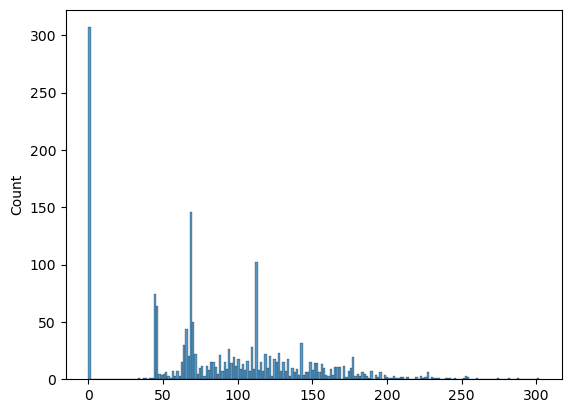

In [24]:
import seaborn as sns
all_lengths_s = sorted(all_lengths, reverse=True)
sns.histplot(all_lengths_s, bins=200, )
# Ограничим максимальную длину ответа 300 символами

In [25]:
# my_dataset_dict.push_to_hub(repo_id='kontur_squad2', private=True)

### Дообучение модели ALexKay

In [26]:
# kontur_data = load_dataset('Dersty/kontur_squad2', use_auth_token=True)
kontur_data = my_dataset_dict

In [27]:
len(kontur_data['train'])

1349

In [28]:
max_length = 384
stride = 128


def preprocess_training_examples(examples):
    '''Обработка для тренировочного датасета'''
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    sample_map = inputs.pop("overflow_to_sample_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    # offset -> list of offsets for one separated_sample
    for i, offset in enumerate(offset_mapping):
        sample_idx = sample_map[i]
        answer = answers[sample_idx]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label is (0, 0)
        if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

def preprocess_validation_examples(examples):
    '''Обработка для валидационного датасета'''
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_map = inputs.pop("overflow_to_sample_mapping")
    example_ids = []

    for i in range(len(inputs["input_ids"])):
        sample_idx = sample_map[i]
        example_ids.append(examples["id"][sample_idx])

        sequence_ids = inputs.sequence_ids(i)
        offset = inputs["offset_mapping"][i]
        inputs["offset_mapping"][i] = [
            o if sequence_ids[k] == 1 else None for k, o in enumerate(offset)
        ]


    inputs["example_id"] = example_ids
    return inputs

In [29]:
train_dataset = kontur_data["train"].select(range(100)).map(
    preprocess_training_examples,
    batched=True,
    remove_columns=kontur_data["train"].column_names,
)
len(kontur_data["train"]), len(train_dataset)

  0%|          | 0/1 [00:00<?, ?ba/s]

(1349, 215)

In [30]:
validation_dataset = kontur_data["test"].select(range(20)).map(
    preprocess_validation_examples,
    batched=True,
    remove_columns=kontur_data["test"].column_names,
)
len(kontur_data["test"]), len(validation_dataset)

  0%|          | 0/1 [00:00<?, ?ba/s]

(450, 44)

In [31]:
model_AlexKay.to(device)

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_23/60184423.py", line 1, in <module>
    model_AlexKay.to(device)
  File "/opt/conda/lib/python3.7/site-packages/transformers/modeling_utils.py", line 1811, in to
    return super().to(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/torch/nn/modules/module.py", line 987, in to
    return self._apply(convert)
  File "/opt/conda/lib/python3.7/site-packages/torch/nn/modules/module.py", line 639, in _apply
    module._apply(fn)
  File "/opt/conda/lib/python3.7/site-packages/torch/nn/modules/module.py", line 639, in _apply
    module._apply(fn)
  File "/opt/conda/lib/python3.7/site-packages/torch/nn/modules/module.py", line 639, in _apply
    module._apply(fn)
  File "/opt/conda/lib/python3.7/site-packages/torch/nn/modules/module.py", line 662, in _apply
    par

TypeError: object of type 'NoneType' has no len()

In [ ]:
args = TrainingArguments(
    './training_val_model',  # только название модели в ХФ?
    log_level = "error",
    num_train_epochs = 2,
    learning_rate = 7e-5,
    lr_scheduler_type = "linear",
    warmup_steps = 10,
    per_device_train_batch_size = 2,
    per_device_eval_batch_size = 1,
    gradient_accumulation_steps = 16,
    # evaluation_strategy = "epoch",
    logging_strategy='epoch',
    save_strategy='no',
    eval_steps = 'epoch',
    # save_steps = 500,
    # logging_steps = 50,
    fp16=True,
    # push_to_hub = True
)


trainer = Trainer(
    # Fine-tune AlexKay model
    model=model_AlexKay,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    tokenizer=tokenizer,
    # compute_metrics=compute_metrics
)
trainer.train()
trainer.save_model()

### Оценка модели

In [32]:
# уже обученная первый раз модель
# my_model = AutoModelForQuestionAnswering.from_pretrained(str(CWD)+"/training_val_model/")
my_model = AutoModelForQuestionAnswering.from_pretrained("Dersty/kontur_squad2_v2")


In [33]:
my_model.to(device)

XLMRobertaForQuestionAnswering(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0): XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, 

In [36]:
def eval_loop(eval_set_data, my_model):
    '''Returns predicted answers and reference answers'''
    eval_set = eval_set_data.map(
      preprocess_validation_examples,
      batched=True,
      remove_columns=kontur_data["test"].column_names,
    )
    eval_set_for_model = eval_set.remove_columns(["example_id", "offset_mapping"])
    eval_set_for_model.set_format("torch")

    batch = {k: eval_set_for_model[k].to(device) for k in eval_set_for_model.column_names}

    example_to_features = collections.defaultdict(list)
    for idx, feature in enumerate(eval_set):
        example_to_features[feature["example_id"]].append(idx)

    with torch.no_grad():
        my_outputs = my_model(**batch)
    
    my_start_logits = my_outputs.start_logits.cpu().numpy()
    my_end_logits = my_outputs.end_logits.cpu().numpy()

    n_best = 20
    max_answer_length = 30
    my_answers = []
    

    for example in eval_set_data:
        example_id = example["id"]
        context = example["context"]
        answers = []

        for feature_index in example_to_features[example_id]:
            start_logit = my_start_logits[feature_index]
            end_logit = my_end_logits[feature_index]
            offsets = eval_set["offset_mapping"][feature_index]

            start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
            end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    if offsets[start_index] is None or offsets[end_index] is None:
                        continue
                    if (
                        end_index < start_index
                        or end_index - start_index + 1 > max_answer_length
                    ):
                        continue
                    if start_index == end_index:
                        answers.append(
                        {
                            "text": context[offsets[start_index][0] : offsets[end_index][0]],
                            "logit_score": start_logit[start_index] + end_logit[end_index],
                        })

                    answers.append(
                        {
                            "text": context[offsets[start_index][0] : offsets[end_index][1]],
                            "logit_score": start_logit[start_index] + end_logit[end_index],
                        }
                    )

        my_best_answer = max(answers, key=lambda x: x["logit_score"])
        my_answers.append({"id": example_id, "prediction_text": my_best_answer["text"].lstrip()})
    theoretical_answers = [
    {"id": str(ex["id"]), "answers": ex["answers"]} for ex in eval_set_data
    ]
    for i in theoretical_answers:
      # i['answers'].pop('answer_start')
      i['answers'].pop('answer_end')
    my_predicted_answers = [
        {"id": str(ex["id"]), "prediction_text": ex["prediction_text"]} for ex in my_answers
    ]
    return my_predicted_answers, theoretical_answers


In [37]:
my_predicted_answers_list = []
theoretical_answers_list = []


for i in tqdm(range(0, 20, 2)):
    eval_set_data = kontur_data['test'].select(range(i, i+2))
    preds, refs = eval_loop(eval_set_data, my_model)
    my_predicted_answers_list.extend(preds)
    theoretical_answers_list.extend(refs)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [38]:
metric = evaluate.load("squad")
# metric_v2 = evaluate.load("squad_v2")
metric.compute(predictions=my_predicted_answers_list, references=theoretical_answers_list)

{'exact_match': 95.0, 'f1': 99.0}

### Дообучение на полных тренировочных данных

In [39]:
train_dataset_all_samples = full_dataset_dict["train"].map(
    preprocess_training_examples,
    batched=True,
    remove_columns=kontur_data["train"].column_names,
)
len(full_dataset_dict["train"]), len(train_dataset_all_samples)

  0%|          | 0/2 [00:00<?, ?ba/s]

(1799, 3511)

In [40]:
# тренировка на всем датасете

args = TrainingArguments(
    './training_final_model',
    log_level = "error",
    num_train_epochs = 2,
    learning_rate = 7e-5,
    lr_scheduler_type = "linear",
    warmup_steps = 10,
    per_device_train_batch_size = 4,
    per_device_eval_batch_size = 2,
    gradient_accumulation_steps = 16,
    logging_strategy='epoch',
    save_strategy='no',
    fp16=True,
)


trainer = Trainer(
    model=my_model,
    args=args,
    train_dataset=train_dataset_all_samples,
    tokenizer=tokenizer,
)
trainer.train()
trainer.save_model()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Step,Training Loss
54,0.278000
108,0.142400


### Получение ответов

In [41]:
!gdown 1__uGp4HNkrO4W1L9--eLfpwlanNGROvK

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Downloading...
From: https://drive.google.com/uc?id=1__uGp4HNkrO4W1L9--eLfpwlanNGROvK
To: /kaggle/working/test.json
100%|███████████████████████████████████████| 1.35M/1.35M [00:00<00:00, 108MB/s]


In [42]:
file_path_test = "test.json"
with open(file_path_test, 'r') as f:
    test_full_file = json.load(f)

In [43]:
def prepare_qa_test(dataset_to_transform:list) -> dict:
    '''Returns dictionary:
      * context
      * questions
    '''


    dict_data = {k: [] for k in ['id', 'question', 'context']}

    for i in range(len(dataset_to_transform)):
        dict_data['id'].append(dataset_to_transform[i]['id'])
        dict_data['question'].append(dataset_to_transform[i]['label'])
        dict_data['context'].append(dataset_to_transform[i]['text'])

    return dict_data

In [44]:
test_data = prepare_qa_test(test_full_file)

test_dataset_ = Dataset.from_dict(test_data)


In [45]:
test_dataset_

Dataset({
    features: ['id', 'question', 'context'],
    num_rows: 318
})

In [46]:
my_model =  AutoModelForQuestionAnswering.from_pretrained(str(CWD)+"/training_final_model/")


In [47]:
my_model.to(device)

XLMRobertaForQuestionAnswering(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0): XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, 

In [48]:
def eval_loop_test(test_data, my_model):
    '''Returns predicted answers'''
    test_dataset = test_data.map(
      preprocess_validation_examples,
      batched=True,
      remove_columns=test_data.column_names,
    )
    test_set_for_model = test_dataset.remove_columns(["example_id", "offset_mapping"])
    test_set_for_model.set_format("torch")

    batch = {k: test_set_for_model[k].to(device) for k in test_set_for_model.column_names}

    example_to_features = collections.defaultdict(list)
    for idx, feature in enumerate(test_dataset):
        example_to_features[feature["example_id"]].append(idx)

    with torch.no_grad():
        my_outputs = my_model(**batch)
    
    my_start_logits = my_outputs.start_logits.cpu().numpy()
    my_end_logits = my_outputs.end_logits.cpu().numpy()

    n_best = 20
    max_answer_length = 300
    my_answers = []
    

    for example in test_data:
        example_id = example["id"]
        context = example["context"]
        answers = []


        for feature_index in example_to_features[example_id]:
            start_logit = my_start_logits[feature_index]
            end_logit = my_end_logits[feature_index]
            offsets = test_dataset["offset_mapping"][feature_index]

            start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
            end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    if offsets[start_index] is None or offsets[end_index] is None:
                        continue
                    if (
                        end_index < start_index
                        or end_index - start_index + 1 > max_answer_length
                    ):
                        continue
                    if start_index == end_index:
                        answers.append(
                        {
                            "text": context[offsets[start_index][0] : offsets[end_index][0]],
                            "logit_score": start_logit[start_index] + end_logit[end_index],
                        })

                    else:
                        answers.append(
                            {
                                "text": context[offsets[start_index][0] : offsets[end_index][1]],
                                "logit_score": start_logit[start_index] + end_logit[end_index],
                            }
                        )

        my_best_answer = max(answers, key=lambda x: x["logit_score"])

        answer_start = context.find(my_best_answer['text'].lstrip(' '))
        answer_end = answer_start + len(my_best_answer['text'].lstrip(' '))

        my_answers.append({"id": example_id, "prediction_text": my_best_answer["text"].lstrip(),
                          'answer_start':answer_start, 'answer_end':answer_end})


    my_predicted_answers = [
        {"id": str(ex["id"]), 
         "extracted_part": {'text': [ex["prediction_text"]],
                            'answer_start':[ex['answer_start']],
                            'answer_end':[ex['answer_end']]}} for ex in my_answers
    ]
    return my_predicted_answers


In [49]:
my_predicted_answers_list = []

for i in tqdm(range(0, 318, 53)):
    test_set_data = test_dataset_.select(range(i, i+53))
    print(i)
    preds = eval_loop_test(test_set_data, my_model)
    my_predicted_answers_list.extend(preds)


  0%|          | 0/6 [00:00<?, ?it/s]

0


  0%|          | 0/1 [00:00<?, ?ba/s]

53


  0%|          | 0/1 [00:00<?, ?ba/s]

106


  0%|          | 0/1 [00:00<?, ?ba/s]

159


  0%|          | 0/1 [00:00<?, ?ba/s]

212


  0%|          | 0/1 [00:00<?, ?ba/s]

265


  0%|          | 0/1 [00:00<?, ?ba/s]

In [50]:
test_data.keys()

dict_keys(['id', 'question', 'context'])

In [51]:
test_data['context'][260]

'ГОСУДАРСТВЕННОЕ АВТОНОМНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХРАНЕНИЯ «ДЕТСКАЯ ГОРОДСКАЯ КЛИНИЧЕСКАЯ БОЛЬНИЦА № 1 Г. ЧЕЛЯБИНСК» ул. Горького, 28, г. Челябинск, Челябинская обл., 454071, Тел/факс +7(351)772-85-93,729-91-51 ИНН 7452021030, ОГРН 1027403775167 УТВЕРЖДЕНО Главным врачом ГАУЗ окументацией о закупке Заказчика, Договором) путем перечисления денежных средств, предоставления банковской гарантии или иным способом, предусмотренным Гражданским кодексом РФ в сумме, сроки и порядке, предусмотренном документацией о закупке, Договором. Банковская гарантия (при выборе ее в качестве обеспечения) должна быть выдана банком, включенным в предусмотренный статьей 74.1 Налогового кодекса Российской Федерации перечень банков, отвечающих установленным требованиям для принятия банковских гарантий в целях налогообложения. В случае выбора независимой гарантии в качестве обеспечения Поставщиком (Подрядчиком, Исполнителем) должны быть соблюдены требования к форме, содержанию и условиям оформления и предоставления е

In [52]:
test_data['id'][260]

423354672

In [53]:
assert len(test_data['context']) == len(my_predicted_answers_list), "unequal"

In [54]:
final_list_to_json = [{} for _ in range(len(test_data['context'])) ]

for i in range(318):
    final_list_to_json[i]['id'] = my_predicted_answers_list[i]['id']
    final_list_to_json[i]['text'] = test_data['context'][i]
    final_list_to_json[i]['label'] = test_data['question'][i]
    final_list_to_json[i]['extracted_part'] = my_predicted_answers_list[i]['extracted_part']


In [55]:
len(final_list_to_json)

318

In [56]:
with open('predictions.json', 'w') as f:
    json.dump(final_list_to_json, f, ensure_ascii=False, indent=2)

In [57]:
with open('predictions.json', 'r') as f:
    a = json.load(f)